In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# set the random number generator
np.random.seed(42)

In [3]:
import csv
import string
import pathlib
import gzip

# Load Data and Inspect
The data is in `./websplit` folder.  

In [4]:
raw_sentences = []  # empty list to store sentences
with open("websplit/test.tsv", "r") as f:
    reader = csv.reader(f, delimiter='\t')  # read a tsv file
    for row in reader:
        # print("Original Sentence:", row[0])      # Uncomment to view data
        # print("Split sentences", row[1].split("<::::>"))
        # print("\n")
        
        raw_sentences.extend(row[1].split("<::::>"))
print("Total Sentences: ", len(raw_sentences))

Total Sentences:  10000


In [5]:
# Some samples
print(raw_sentences[99], '\n', raw_sentences[100])

 He was was arrested and booked on charges of first - degree murder and first - degree robbery . 
 A 2006 estimate by the International Organization for Migration put the number of Sudanese people in the UK at a much higher figure . 


In [6]:
# As we see there are lots of punctuations which we dont have in EMNIST, so we are going to remove them, 
# and replace multiple spaces with one
import re

sentences = []
table = str.maketrans({key: None for key in string.punctuation})  # translation table

for sentence in raw_sentences:
    # remove punctuation and non-ascii characters
    clean_sentence = re.sub('  +', ' ', sentence.translate(table)).\
                        encode("ascii", 'ignore').decode()  
    sentences.append(clean_sentence.strip())  # add to clean sentences
    
print(sentences[99], '\n', raw_sentences[99])  # to verify

He was was arrested and booked on charges of first degree murder and first degree robbery 
  He was was arrested and booked on charges of first - degree murder and first - degree robbery .


# Make Images for Sentences

### First step is to load the EMIST data and the mapping table

In [7]:
import sys
sys.path.append('../')  # so that we can import libs from other chapters and utils

from utils import emnist_utils

In [8]:
######## GPU CONFIGS FOR RTX 2070 ###########
## Please ignore if not training on GPU ##
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True  # dont allocate all memory at once
config.gpu_options.allocator_type = 'BFC'  #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc
config.gpu_options.per_process_gpu_memory_fraction = 2.0  # Use host memory as swap space, may not work on all architectures
config.log_device_placement=True
session = InteractiveSession(config=config)
# K.set_session(session)
##########################################

In [9]:
# Load train and test data from Chapter 1 location
train = {}
test = {}

train['features'], train['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-train-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-test-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-test-labels-idx1-ubyte.gz')

In [39]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")
# Plot some images to verify we got the data right
emnist_utils.display_emnist_images(test['features'], test['labels'], mappings)

NameError: name 'test' is not defined

In [11]:
# To help in converting a list of characters into a sequence of images, 
# we need a list of image IDs corresponding to the same character
# or number. So, a reverse index needs to be generated
image_index = {}  # where key is the char and value is a list of IDs
for idx, code in enumerate(train['labels'].tolist()):
    char = mappings[code]
    if char in image_index:
        # this character already exists
        image_index[char].append(idx)  # append index
    else:
        image_index[char] = [idx]  # initiate list with 1 item

### Second step is to load sentence at a time, create set of images that can be joined with each other to produce the sentence.

In [12]:
def get_sample_sentences(sentences_in=sentences, num_sentence=10):
    # Get a defined number of sentences from the data
    return np.random.choice(sentences_in, num_sentence)

def get_generated_image(words, chars=train['features'], index=image_index):
    # words is string of char/numbers that needs to be converted into an image
    # chars is a data set of images that need to be used to compose, usually pass in train['features'] in here
    # index maps a character to indexes in the images, available as dictionary
    height, width = train['features'][0].shape # height and width of each character
    length = len(words) # total number of characters in the image
    
    # create an empty array to store the data
    image = np.zeros((height, width * length))
    pos = 0  # starting index of the character
    
    for char in words:
        if char is ' ':
            pos += width # if space, move over
        else:
            if char in image_index:
                # pick a random item from all images for that char
                idx = np.random.choice(image_index[char])  
                image[:, pos:(pos+width)] += chars[idx]
            elif char.upper() in image_index:  # to remove characters from other languages
                # for some characters, there is only upper case
                idx = np.random.choice(image_index[char.upper()])  
                image[:, pos:(pos+width)] += chars[idx]
            
            pos += width
    
    return image

['His father abandoned the family when he was only 8 years old']


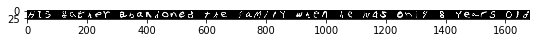

In [13]:
# Let's print a sample to see how it looks
s = get_sample_sentences(sentences, 1)
print(s)
img = get_generated_image(s[0])
plt.figure(figsize=(9,2))
plt.imshow(img, cmap='gray')
plt.show()

### Third step is to generate a number of sentences for training and testing and save them to disk for processing

In [14]:
train_sentences = sentences[:9000]
test_sentences = sentences[9000:]

# Lets assume that for each training sample, 2 variants will be generated

def generate_sentences(texts, chars, 
                           index, num_variants=2, max_length=32):
    # this method takes input text lines, character samples and labels
    # and generates images. It can generate multiple images per sentence
    # as controlled by num_variants parameter. max_length parameter
    # ensures that all sentences are the same length
    
    # total number of samples to generate
    num_samples = len(texts) * num_variants
    height, width = chars[0].shape  # shape of image
    
    # setup empty array of the images
    images = np.zeros((num_samples, height, width * max_length), np.float64)
    labels = []
    
    for i, item in enumerate(texts):
        padded_item = item[0:max_length] if (len(item) > max_length) else item.ljust(max_length, ' ')
        
        for v in range(num_variants):
            img = get_generated_image(padded_item, chars, index)
            images[i*num_variants+v, :, :] += img
            labels.append(padded_item)
    
    return images, labels

In [ ]:
train_images, train_labels = generate_sentences(train_sentences, train['features'], image_index)
test_images, test_labels = generate_sentences(test_sentences, train['features'], image_index)

In [ ]:
# Now to save these models for easy loading
pp = pathlib.Path('.') / 'sentences'
pp.mkdir(exist_ok=True)  # create the directory

np.save(pp / 'train_images', train_images)
np.save(pp / 'test_images', test_images)
np.save(pp / 'train_labels', train_labels)
np.save(pp / 'test_labels', test_labels)

In [15]:
# free up space
del raw_sentences, train, test

# Building the Model to Recognize Sentences

In [16]:
# Lets load the zipped Numpy files from disk and hydrate the training and test data
pp = pathlib.Path('.') / 'sentences'

# training labels and images
file = gzip.GzipFile(pp / 'train_labels.npy.gz', 'r')
train_labels = np.load(file)
file = gzip.GzipFile(pp / 'train_images.npy.gz', 'r')
train_images = np.load(file)

# test labels and images
file = gzip.GzipFile(pp / 'test_labels.npy.gz', 'r')
test_labels = np.load(file)
file = gzip.GzipFile(pp / 'test_images.npy.gz', 'r')
test_images = np.load(file)

Bandolier Budgie a free iTunes a


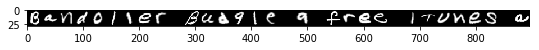

In [17]:
# Sample some to check
print(train_labels[1])
plt.figure(figsize=(9,2))
plt.imshow(train_images[1], cmap='gray')
plt.show()

In [18]:
train_images.shape

(18000, 28, 896)

In [19]:
def extract_patches(image):
    kernel = [1, 1, patch_width, 1]
    strides = [1, 1, patch_stride, 1]
    patches = tf.image.extract_patches(image, kernel, strides, [1, 1, 1, 1], 'VALID')
    print(patches)
    # output of previous is [None, 28, 63, 20]. should be [none, 63, 28, 20]
    patches = tf.transpose(patches, (0, 2, 1, 3))  # why transpose?
    print(patches)
    patches = tf.expand_dims(patches, -1)
    print(patches)
    return patches

In [47]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")
mappings[47] = ' '  # add a space for spacing words
inverse_mappings = {v: k for k, v in mappings.items()}

In [59]:
# CNN definition : LeNet5 architecture, a classic architecture
# Based on paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import Dense, Input, Reshape, Lambda,  TimeDistributed


image_height, image_width = train_images[1].shape
output_length = 32  # we limited output sentences to 32 chars
# EMNIST dimensions are 47, adding one for 'blank label'
num_classes = 49  # lets see if this works 

# Since each image is a sentence, we will extract patches from it
# width of each patch will be 20 pixels wide (note EMNIST is 28 px)
# and every time we will move 14 px over to extract another sample
# This may result in same char be detected multople times but that is ok
patch_width = 20
patch_stride = 14

# construct the patches
image_input = Input(shape=(image_height, image_width), name="cnn_input")

# reshape to add dimensions
image_reshaped = Reshape((image_height, image_width, 1))(image_input)
    
# extract patches of images
image_patches = Lambda(extract_patches)(image_reshaped)
print(image_input.shape, image_reshaped.shape, image_patches.shape)

leNet = Sequential()
leNet.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=(image_height, image_width, 1)))
leNet.add(Conv2D(64, (3, 3), activation='relu'))
leNet.add(MaxPooling2D(pool_size=(2, 2)))
leNet.add(Dropout(0.2))
leNet.add(Flatten())
#leNet.add(Dense(128, activation='relu'))
# Note the last drop out and activation layers are removed
# because the out put of this network feeds another network

leNet_out = Model(inputs=leNet.inputs, outputs=leNet.output)
leNet_out.summary()

# (num_windows, 128)
leNet = TimeDistributed(leNet_out)(image_patches)
#leNet_out = TimeDistributed(leNet)(image_patches)


print(leNet)
#leNet.summary()

Tensor("lambda_7/ExtractImagePatches:0", shape=(None, 28, 63, 20), dtype=float32)
Tensor("lambda_7/transpose:0", shape=(None, 63, 28, 20), dtype=float32)
Tensor("lambda_7/ExpandDims:0", shape=(None, 63, 28, 20, 1), dtype=float32)
(None, 28, 896) (None, 28, 896, 1) (None, 63, 28, 20, 1)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10_input (InputLayer) [(None, 28, 896, 1)]      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 894, 32)       320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 892, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 446, 64)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 

In [60]:
print("Image:", image_input.shape, "; reshaped:", image_reshaped.shape,
      "; Image patches:", image_patches.shape, ";" )

Image: (None, 28, 896) ; reshaped: (None, 28, 896, 1) ; Image patches: (None, 63, 28, 20, 1) ;


In [61]:
# Now, lets buid the LSTM model
from tensorflow.keras.layers import  Permute, RepeatVector, LSTM, GRU, Bidirectional

lstm_out = LSTM(128, return_sequences=True, name="lstm")(leNet)
# (num_windows, 128)

softmax_output = Dense(num_classes, activation='softmax', name="lstm_softmax")(lstm_out)
# This is (?, 63, 47)

#softmax_output = tf.transpose(softmax_output, [1, 0, 2])

In [62]:
# now convert categorical labels from the sentences
# we need this to compute loss
encode = lambda x: [inverse_mappings[xi] if xi in inverse_mappings else inverse_mappings[xi.upper()] for xi in x]
decode = lambda x: [mappings[xi] for xi in x]

train_labels_cat = np.array([encode(xi) for xi in train_labels])
test_labels_cat = np.array([encode(xi) for xi in test_labels])

# Verify the encoding/decoding
print(train_labels[1])
print(train_labels_cat.shape, train_labels_cat[1])
print(decode(train_labels_cat[1]))

Bandolier Budgie a free iTunes a
(18000, 32) [11 36 43 38 24 21 18 39 45 47 11 30 38 41 18 39 47 36 47 40 45 39 39 47
 18 29 30 43 39 28 47 36]
['B', 'a', 'n', 'd', 'O', 'L', 'I', 'e', 'r', ' ', 'B', 'U', 'd', 'g', 'I', 'e', ' ', 'a', ' ', 'f', 'r', 'e', 'e', ' ', 'I', 'T', 'U', 'n', 'e', 'S', ' ', 'a']


In [63]:
output_length

32

In [70]:
num_windows = int((image_width - patch_width) / patch_stride) + 1
input_length = Input(shape=(1,), name="lstm_inp_len")

y_true = Input(shape=(32,), name='y_true')
label_length = Input(shape=(1,), name='label_length')


input_length_processed = Lambda(
    lambda x, num_windows=None: x * num_windows,
    arguments={'num_windows': num_windows}
)(input_length)

print(y_true.shape, softmax_output.shape, input_length_processed.shape, label_length.shape)

print(y_true, train_labels_cat.shape, softmax_output.shape, input_length_processed.shape, 
      num_windows) #, input_length_processed.shape, label_length.shape)

def ctc_loss(y_true, y_pred, inp_len_proc2, lab_length):
    # This function ensures that the predicted and and ground truths
    # are of the right lengths. Particularly the predicted values may have less than
    # expected items causing issues with CTC loss calculation
    #tf.print("computing ctc_loss")
    #tf.print(y_true.shape)
    #tf.print(y_pred.shape)
    _, window, classes = y_pred.shape
    #for i in range(batch):
    # lets try to verify the batch sizes
    used = tf.sign(tf.reduce_max(tf.abs(y_pred), 2))
    length = tf.reduce_sum(used, 1)
    length = tf.cast(length, tf.int32)
    #tf.print("length of ", "0", " is ", length)
    #tf.print("Truth:", y_true[0,:], lab_length[0], summarize=63, sep=', ')
    #tf.print("Learned vals:", y_pred[0, :].shape, inp_len_proc2[0], summarize=63, sep=', ')
    #tf.print("Learned vals:", inp_len_proc2[0], summarize=63, sep=', ')
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, inp_len_proc2, lab_length)
    #loss = tf.nn.ctc_loss(y_true, softmax_output, input_length_processed, label_length, time_major=False)
    return loss
    

ctc_loss_output = Lambda(
    lambda x: ctc_loss(x[0], x[1], x[2], x[3]), 
    name='ctc_loss_new'
)([y_true, softmax_output, input_length_processed, label_length])


'''
ctc_loss_output = Lambda(
    lambda x: keras.backend.ctc_batch_cost(x[0], x[1], x[2], x[3]), 
    name='ctc_loss'
)([y_true, softmax_output, input_length_processed, label_length])

ctc_loss_output = Lambda(
    lambda x: tf.nn.ctc_loss(
    x[0], x[1], x[2], x[3])
    name='ctc_loss'
)([y_true, softmax_output, input_length_processed, label_length])
'''

ctc_decoded_output = Lambda(
    lambda x: keras.backend.ctc_decode(x[0], keras.backend.squeeze(x[1], axis=-1)),
    name='ctc_decoded'
)([softmax_output, input_length_processed])

                                       
                                       
#, input_length, label_length
model = Model(
    inputs=[image_input, y_true, input_length, label_length],
    outputs=[ctc_loss_output, ctc_decoded_output], name="CNN+RNN"
)

model.summary()

(None, 32) (None, 63, 49) (None, 1) (None, 1)
Tensor("y_true_3:0", shape=(None, 32), dtype=float32) (18000, 32) (None, 63, 49) (None, 1) 63
Model: "CNN+RNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 28, 896)]    0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 28, 896, 1)   0           cnn_input[0][0]                  
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 63, 28, 20, 1 0           reshape_5[0][0]                  
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 63, 6144)   

In [65]:
y_true


<tf.Tensor 'y_true_2:0' shape=(None, 32) dtype=float32>

In [71]:
# compile the models
model.compile(tf.keras.optimizers.Adam(),
              loss= {'ctc_loss_new': lambda y_true, y_pred: y_pred})


W0830 00:31:15.422699 139626645329728 training_utils.py:1237] Output ctc_decoded missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to ctc_decoded.
W0830 00:31:15.424339 139626645329728 training_utils.py:1237] Output ctc_decoded_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to ctc_decoded_1.


In [67]:
inp_len = np.zeros([18000,1]) + 1
lbl_len = np.zeros([18000,1]) + 32

inp_len.shape

(18000, 1)

In [68]:
print(train_images.shape, train_labels_cat.shape)
print(train_labels_cat[1])

(18000, 28, 896) (18000, 32)
[11 36 43 38 24 21 18 39 45 47 11 30 38 41 18 39 47 36 47 40 45 39 39 47
 18 29 30 43 39 28 47 36]


In [72]:

# try taining,      , inp_len, lbl_len
#history = model.fit([train_images, train_labels_cat, inp_len, lbl_len], train_labels_cat,
#                   batch_size=32, epochs=1, verbose=2)

# try taining,      , inp_len, lbl_len
history = model.fit([train_images, train_labels_cat, inp_len, lbl_len], train_labels_cat,
                    epochs=1, verbose=2)

Train on 18000 samples
18000/18000 - 78s - loss: 17.4330 - ctc_loss_new_loss: 17.4265


In [75]:
print(test_images.shape, test_labels_cat.shape)
print(test_labels_cat[1])

(2000, 28, 896) (2000, 32)
[29 42 39 45 39 47 36 45 39 47 36 25 25 45 24 33 18 22 36 46 39 21 34 47
  2  0  0  0 47 22 36 43]


In [80]:
model.summary()

Model: "CNN+RNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 28, 896)]    0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 28, 896, 1)   0           cnn_input[0][0]                  
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 63, 28, 20, 1 0           reshape_5[0][0]                  
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 63, 6144)     18816       lambda_7[0][0]                   
____________________________________________________________________________________________

In [86]:
# Create a simplified version of the network for inference
softmax_output = keras.backend.function(
            [model.get_layer('cnn_input').input],
            [model.get_layer('lstm_softmax').output]
        )

test_image = np.expand_dims(test_images[0], 0)
predicted_output = softmax_output([test_image, 0])[0]

input_length = np.array([predicted_output.shape[1]])
decoded, log_prob = keras.backend.ctc_decode(predicted_output, input_length, greedy=True)

print(decoded)
pred_raw = keras.backend.eval(decoded[0])[0]
pred = ''.join(mappings[label] for label in pred_raw).strip()

neg_sum_logit = keras.backend.eval(log_prob)[0][0]
conf = np.exp(-neg_sum_logit)

print("Prediction: ", pred, " with confidence: ", conf)
print("actual: ", ''.join(mappings[label] for label in test_labels_cat[0]))

[<tf.Tensor: id=19431, shape=(1, 31), dtype=int64, numpy=
array([[29, 42, 39, 45, 39, 47, 36, 45, 39, 47, 36, 25, 25, 45, 24, 33,
        18, 22, 36, 46, 39, 21, 34, 47,  2, 24, 24, 24, 47, 22, 36]])>]
Prediction:  There are aPPrOXIMateLY 2OOO Ma  with confidence:  6.942371e-05
actual:  There are aPPrOXIMateLY 2000 Man


In [79]:
outpredict_len = np.zeros([2000,1]) + 1
outtrue_len = np.zeros([2000,1]) + 33
result = model.predict([test_images, test_labels_cat, outpredict_len, outtrue_len], batch_size=1)

ValueError: could not broadcast input array from shape (1,32) into shape (1,31)

In [73]:

from notebook.services.config import ConfigManager
ip = get_ipython()
cm = ConfigManager(parent=ip)
cm.update('notebook', {"ruler_column": [80]})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'load_extensions': {'jupyter-js-widgets/extension': True,
  'nbextensions_configurator/config_menu/main': True,
  'contrib_nbextensions_help_item/main': True,
  'ruler': True,
  'Ruler': True},
 'ruler_column': [80]}

In [ ]:
tf.__version__


In [ ]:
tf.test.is_gpu_available()

In [ ]:
tf.test.is_built_with_cuda()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
K2 = keras.backend

X = np.zeros((1, 2))

class MyLayer(keras.layers.Layer):
    @tf.function
    def call(self, inputs, training=None):
        tf.print("training: ", training)
        tf.print("K.learning_phase(): ", K2.learning_phase())
        return keras.backend.in_test_phase(inputs + 1., inputs + 2., training)

model1 = keras.models.Sequential([MyLayer(input_shape=[2])])
model1.compile(loss="mse", optimizer="sgd")

In [ ]:
history = model1.fit(X, X, epochs=2)

In [ ]:
np.argmax([0.0232960675, 0.0195535328, 0.016626576,  0.0414558575, 0.0135532925, 0.0172119308])

In [ ]:
a = '''[[0.0228137393 0.0227731019 0.0249607656 0.0122186402 0.0154442303 0.0182294585 0.0305795707 0.01049254 0.0109093478 0.0289295651 0.0296889748 0.0143930949 0.026128646 0.0276961308 0.0192467216 0.028707182 0.0200237222 0.0177078936 0.0109403934 0.011780262 0.0173202157 0.0243938398 0.0319331 0.0155423628 0.0161838289 0.0131940544 0.0133310976 0.0238287058 0.0123948995 0.014269094 0.0262083374 0.0356328078 0.0468103215 0.0480685495 0.0166015029 0.0256421249 0.0253335536 0.00994496 0.0190705378 0.019713657 0.0191894341 0.014858542 0.0263540298 0.0144016976 0.0293591432 0.0130941179 0.02366147]
 [0.0187760256 0.0066402168 0.0131739127 0.0089333253 0.0189876631 0.0227136761 0.0207491834 0.0232274402 0.027918702 0.0583300851 0.0214756392 0.0103822798 0.018456744 0.0305445902 0.0359705724 0.0223798174 0.0162829459 0.0193380062 0.0107467696 0.0188836604 0.0129799815 0.0209707115 0.0103605371 0.0201060828 0.0332009085 0.0373613127 0.034071926 0.0171593446 0.0219634473 0.0214003175 0.0362009667 0.0222178381 0.0380399488 0.0266473163 0.0227537379 0.0190783 0.0301708952 0.0151826795 0.00778692681 0.00672566099 0.0141359195 0.0134200929 0.0127874743 0.0185814407 0.0275702402 0.0214475468 0.0137671717]
 [0.0168813262 0.0354622453 0.0114423316 0.0143896146 0.0227771346 0.0110805752 0.0209274329 0.0200254545 0.0180668011 0.014424785 0.0430333465 0.0158726461 0.0221074484 0.0250866432 0.0222040713 0.023250699 0.0162146166 0.0355605818 0.0187020153 0.019669313 0.0148019595 0.0165950973 0.028835116 0.0182044636 0.0143027045 0.0222248081 0.0258371308 0.014754788 0.0247846805 0.0407129526 0.024382608 0.0192060247 0.0327107385 0.031598419 0.0124389436 0.0297969673 0.0338452756 0.0204746239 0.0178271588 0.00909764878 0.0163201448 0.00997424219 0.0280039515 0.0174370725 0.012013386 0.0167801734 0.0198598355]
 [0.00861544069 0.0213697385 0.0203956 0.0222424511 0.0206412822 0.0103699565 0.0325003639 0.0183934178 0.0178898554 0.0341780782 0.0118095856 0.0251186341 0.020492278 0.0564898327 0.0243697055 0.0313388072 0.0161057059 0.0203737784 0.0145141101 0.0414159335 0.0217499305 0.0211218446 0.0175034609 0.0127203371 0.0266286526 0.0192737654 0.0298574232 0.0100951726 0.0115202237 0.0374734066 0.0212538075 0.0212676357 0.00664795935 0.0189572666 0.0195410307 0.0241697505 0.0534488782 0.0364909433 0.0187185537 0.00977574848 0.0163571779 0.00781718735 0.00896536279 0.0129906032 0.0199956186 0.0113381185 0.0156956054]
 [0.0150571764 0.0209780894 0.0258761402 0.0278841015 0.0165325906 0.020352589 0.0230885595 0.0274921916 0.0154652307 0.0237931367 0.0198170375 0.0243192147 0.0208700057 0.0380286686 0.0215106346 0.0340898633 0.0147271277 0.026873013 0.00978204329 0.0304722488 0.0200374685 0.0260388814 0.0255236868 0.0117134778 0.0226622149 0.0232532825 0.0187239423 0.0132897366 0.0202130079 0.0294537563 0.0197565276 0.0231442247 0.0154423788 0.0232206 0.0165114067 0.0208213944 0.0340669155 0.0329520628 0.0195775647 0.0121582085 0.0256321914 0.011034647 0.0109863039 0.0143016912 0.0184585899 0.0193564594 0.0146596897]
 [0.0153023396 0.00831586774 0.0347512625 0.0172359701 0.0104365041 0.0223026294 0.0263470542 0.0236560684 0.0175942034 0.0268340744 0.0337377228 0.0188602973 0.0326346047 0.0335275419 0.0218725987 0.0260910969 0.0110841626 0.0187041648 0.0242564753 0.0225780401 0.0177378673 0.0246976037 0.02650165 0.0127393147 0.0150060859 0.0152985202 0.0237627514 0.0385751501 0.013400496 0.0320881903 0.0146967089 0.0219654553 0.0377097465 0.0186380707 0.0269983374 0.018311251 0.0134218084 0.0173744448 0.0214998368 0.0162613522 0.027103249 0.0142260753 0.0177187268 0.0151662333 0.0132436343 0.0160895512 0.0236452147]
 [0.0276701301 0.0106175365 0.0315217748 0.00544833485 0.0153050721 0.0121421758 0.0242422074 0.0107863508 0.0320827067 0.0150338868 0.0477577746 0.0217335634 0.0192814041 0.053845495 0.0273463726 0.0241027661 0.0135521227 0.0191254057 0.0195590109 0.0130896503 0.0206217375 0.0183121208 0.019075999 0.00993885379 0.0112843532 0.020403469 0.0157508682 0.0166858472 0.00505209947 0.036241781 0.0135745602 0.0246062223 0.0258287694 0.0331226252 0.0256763399 0.0145303747 0.0319651477 0.01488687 0.0241727345 0.0164582971 0.0263439752 0.0277846083 0.0361094438 0.0100527629 0.019355705 0.0177364107 0.0201843474]
 [0.0337082259 0.00933350716 0.0147700543 0.013884455 0.016273668 0.0371985361 0.0125842961 0.00450976845 0.0361446813 0.0149371577 0.0166526269 0.0204706471 0.0232055578 0.0228382647 0.021205971 0.0188571606 0.0180174112 0.0264877863 0.028316915 0.0184813272 0.011966317 0.0256415289 0.0462828316 0.0214242283 0.012224338 0.0210782234 0.0166834686 0.0150245279 0.0117384149 0.034360446 0.0199781973 0.0252182875 0.0130935106 0.0176837035 0.0244865566 0.04971461 0.0357606336 0.0137073239 0.0178960524 0.0201973505 0.020775117 0.0203843527 0.0226700269 0.0100291986 0.00866455398 0.0154151861 0.0400229767]
 [0.0229533985 0.0269023292 0.015093619 0.0277580488 0.0250800438 0.00989113282 0.0300698113 0.00374573562 0.0186586976 0.0149968937 0.0193121 0.0220379941 0.0330955 0.0289141163 0.0246596839 0.0223356467 0.0214601 0.0236667339 0.0960004 0.0342255384 0.0075708176 0.0271372367 0.031433139 0.00811110809 0.00790713 0.0234635882 0.0156640317 0.0368324667 0.0130991023 0.0354804359 0.00890062749 0.0117499325 0.0192471705 0.0122010279 0.0167768691 0.0426612 0.0209248867 0.00922675338 0.0162751582 0.016147783 0.0163093973 0.00849448796 0.0158934165 0.0131781856 0.00904153 0.0134651186 0.0219498333]
 [0.0153414989 0.00798675884 0.0148888947 0.0172195937 0.0252617244 0.0101270918 0.0343063846 0.0128675271 0.0396226346 0.0153428968 0.037934538 0.0146528808 0.0326013416 0.0153466882 0.0125070103 0.0232418887 0.0164708626 0.019972574 0.034553811 0.0192156322 0.0168287568 0.0358941667 0.016178 0.0110801738 0.0205407944 0.0176337063 0.00666432874 0.0277049653 0.00784012582 0.0396507084 0.0170409493 0.0221371707 0.0149733173 0.0136302877 0.0245731603 0.0364529267 0.02304665 0.0152909216 0.0174896 0.0314492323 0.0175704956 0.0472424068 0.017813636 0.0127617307 0.0315968208 0.0154894544 0.0219632927]
 [0.016395038 0.0132368486 0.0274777319 0.0242939219 0.0262390655 0.00656434242 0.0239858758 0.0154964831 0.0163690113 0.0148311239 0.0232908893 0.020293748 0.0209031533 0.0353234746 0.0208381917 0.03398728 0.0221984964 0.0286356844 0.0178825613 0.0200419948 0.0157555081 0.019262353 0.0203470197 0.00529728644 0.0274417121 0.0165844094 0.0260909852 0.0296199918 0.012892697 0.0264749676 0.0248563718 0.0269066412 0.0137310484 0.0251885597 0.0274665635 0.042758882 0.0341157578 0.0176564958 0.0171150956 0.0206382722 0.0210209917 0.00961488206 0.014135899 0.00571053615 0.0226037335 0.0242075771 0.0242208764]
 [0.0352959484 0.0103442827 0.0140661336 0.014638667 0.0185423642 0.0117845302 0.0252548177 0.00650200155 0.0420816205 0.0270338133 0.011841164 0.0139940735 0.0305830967 0.0359388851 0.0203119908 0.0178917982 0.0124624697 0.0177088063 0.0124761183 0.0472171828 0.0341421738 0.0216573309 0.0155089665 0.0125190364 0.0273100846 0.0224959087 0.0220959149 0.0264494214 0.00893438142 0.0256368108 0.022778701 0.0193534978 0.0210160613 0.0203498416 0.0138749639 0.0195741057 0.0157356411 0.0133131035 0.0268272981 0.0351584181 0.0234481972 0.0232518576 0.0147768138 0.0153720686 0.0204935092 0.0370383561 0.0149177248]
 [0.0229492672 0.0134942662 0.0179181863 0.0168033149 0.014855532 0.00765293697 0.050774347 0.0102432 0.0127731115 0.0237646215 0.0291053895 0.0142575707 0.0146203171 0.0494777821 0.00899273902 0.0372232161 0.0154465474 0.0226255395 0.0247936733 0.0150713362 0.00992622 0.0269904789 0.0324623436 0.00784106739 0.0267066155 0.0185585693 0.0118774511 0.036500033 0.00529868389 0.0442418754 0.0256752688 0.02682315 0.0182115771 0.0132304411 0.0190071426 0.0336025022 0.0154306758 0.0263475217 0.0235783849 0.022736853 0.0260110218 0.0186846592 0.015873773 0.00664044777 0.0233475082 0.0220512953 0.0195015259]
 [0.0245696176 0.0075397375 0.0197934601 0.0117257927 0.0121621061 0.0147525882 0.0179688018 0.0133148534 0.033180654 0.0290172882 0.0123409573 0.0153972851 0.0350240096 0.061959181 0.00691874838 0.0203306098 0.0178833641 0.015688071 0.0193603709 0.0252870042 0.0182077531 0.021356931 0.0116939396 0.0107970219 0.0581085235 0.0256818756 0.0313093588 0.0228544548 0.0106982403 0.0480484515 0.0326305032 0.0245973263 0.00927386526 0.0156937484 0.0306181237 0.0338827372 0.0186658315 0.0175670553 0.0118007511 0.0148565331 0.0140952291 0.0108463708 0.0117359152 0.00891875941 0.0143937552 0.018804295 0.0386481732]
 [0.0254670456 0.0229903 0.0130686583 0.0239504464 0.0189353637 0.00771667203 0.0294109751 0.0195986852 0.0106222071 0.00529464 0.038074635 0.0159253627 0.018068647 0.0438326113 0.0107491938 0.0284888297 0.0161336381 0.00864618644 0.0116266748 0.00989178661 0.0141344145 0.0219446011 0.0461838357 0.00947530847 0.0145511469 0.0184990913 0.0414822809 0.0189250186 0.00669179298 0.0469531342 0.0196197592 0.034533672 0.019608466 0.0586971045 0.00445839763 0.0138810929 0.00987593178 0.0255980585 0.0193469264 0.0132608898 0.0204230919 0.0167173222 0.0194622036 0.00524453307 0.0161328577 0.0469319187 0.0388745405]
 [0.00754725561 0.0097904373 0.0123945922 0.0147785246 0.0229291208 0.010994208 0.0599026792 0.0156883076 0.0170746837 0.0111604696 0.018191535 0.030159384 0.0156064192 0.0487751886 0.0131732235 0.027199164 0.0310240425 0.0211349651 0.0198503304 0.0345340371 0.015424584 0.0438864715 0.0179727152 0.0105632199 0.0147168869 0.0524068363 0.0217765179 0.0209356453 0.00806206837 0.0480476357 0.0241096672 0.0176736489 0.0227762591 0.0264533218 0.0122715589 0.0345710255 0.0118604 0.0118551543 0.00633148337 0.0143826418 0.0210428759 0.0117024118 0.0180298183 0.00920954626 0.0256189071 0.0233688354 0.0130412038]
 [0.0167583656 0.0149458712 0.013871707 0.0171986558 0.0363631882 0.0134891598 0.0155910803 0.0102888616 0.0234313738 0.00726291491 0.0199944377 0.0150339315 0.0313669331 0.0390512832 0.0205741618 0.0122767352 0.0245639756 0.0219569225 0.0333826914 0.0252772458 0.00658987975 0.0369050838 0.0329883844 0.0131469676 0.0195769966 0.0284931399 0.0165366456 0.015792381 0.00752105564 0.042164389 0.0142392805 0.0336769968 0.00892652292 0.0127922306 0.0163850039 0.0583966337 0.0138741722 0.0249936804 0.0249283928 0.0349312276 0.0172293447 0.0152337542 0.0299231 0.005692882 0.0144316917 0.0195511058 0.0223995857]
 [0.00605089916 0.0298865214 0.0155108618 0.010037737 0.0140728848 0.0108739333 0.032648623 0.0232213903 0.0207689777 0.00973652676 0.033949662 0.0240422711 0.0275504738 0.0359765887 0.0143972766 0.0192090534 0.0202448592 0.0155640515 0.0351524577 0.0112743471 0.0156052634 0.045272287 0.030451186 0.0242620073 0.029067304 0.023442531 0.0205320511 0.0163616203 0.0116661089 0.0413129814 0.0282307714 0.0239764564 0.0205872431 0.0241611321 0.02201703 0.0240982715 0.0161470901 0.0265284386 0.0133990133 0.0241511725 0.010161222 0.01843068 0.00834624 0.0197149534 0.0169895 0.0134062935 0.0215117428]
 [0.0105161546 0.0197333917 0.012201163 0.0121029783 0.0136035662 0.0242523365 0.0191349555 0.00874256901 0.0303626154 0.00956785213 0.0340415724 0.0261465386 0.0128052058 0.0471541472 0.0133765256 0.00611139648 0.0289696828 0.0151133835 0.0212852079 0.0178958513 0.0131750964 0.0144626228 0.0416826829 0.0414922088 0.0173839629 0.0204560831 0.0118466811 0.0177776553 0.0065764566 0.0428120494 0.0192912798 0.0178157948 0.0235929769 0.0232075397 0.0181505345 0.0483440906 0.00853943825 0.0241972189 0.0127830179 0.036525324 0.00957014225 0.0226990469 0.0172409341 0.0160330068 0.0211608112 0.0325493701 0.0375169069]
 [0.0167497434 0.0131898224 0.0103658801 0.0193637703 0.00897275843 0.0135650914 0.0189336315 0.0311544854 0.0268190615 0.01140677 0.0211609919 0.0176965855 0.0206333734 0.0429896675 0.0278116241 0.0220345035 0.0168122519 0.0143777821 0.0213861745 0.0238133259 0.0176781919 0.0109399799 0.0284505263 0.0424909778 0.0417587161 0.0370324254 0.023176644 0.0164987892 0.0131286681 0.0195234139 0.051401142 0.0385744385 0.0221095607 0.025567133 0.0348931253 0.0116428221 0.0181423 0.0251269415 0.010546742 0.0178636499 0.00655271392 0.0162116289 0.0150307575 0.0102319643 0.0212224908 0.0122975316 0.012669378]
 [0.010424275 0.022438433 0.00989560131 0.0253430251 0.00895593129 0.0206544176 0.0452825613 0.0121644065 0.0174360443 0.0150203621 0.0343090072 0.0323179029 0.0180282053 0.0478974245 0.0295276158 0.0260339268 0.0218539182 0.017727999 0.0379394405 0.0357402 0.0155629683 0.0168340374 0.0236802045 0.043143969 0.0237575751 0.0219801441 0.0146953072 0.0176656805 0.0195703674 0.0126181645 0.021139361 0.0205594786 0.0136719914 0.0191170909 0.0164905619 0.0293325856 0.0135005908 0.0303947758 0.0154897 0.0188711938 0.0053853034 0.0121347895 0.01007785 0.00822779257 0.00910032075 0.0225977935 0.0354096703]
 [0.0108103557 0.0158205442 0.017550787 0.0201388523 0.0246687848 0.00912501 0.0356603079 0.0408383608 0.0251090247 0.0222699046 0.0464930534 0.0175102595 0.0225942247 0.0842246488 0.0299146324 0.0230355412 0.0175127722 0.0128764259 0.0168179665 0.0262199976 0.0141908647 0.0367596708 0.00832826 0.0149971135 0.0174137242 0.03553183 0.0214534 0.0198628325 0.0110942693 0.0232390463 0.0193894431 0.0139808673 0.0144126266 0.0306528527 0.022973543 0.0185050778 0.010505504 0.0173264109 0.00915706 0.0138273323 0.0102435546 0.0183858089 0.0130994963 0.00698669162 0.022554107 0.0169377699 0.0189994369]
 [0.0261242297 0.0118700797 0.0118861189 0.029627135 0.0199670251 0.010325985 0.0289956667 0.0273941532 0.0118277399 0.0124313254 0.0390854813 0.02033245 0.0153239137 0.0429333262 0.0332379676 0.0179887842 0.00843315572 0.0133546963 0.0143182194 0.0266555082 0.0376628935 0.0508475043 0.0268050823 0.0181758702 0.0142825134 0.0114324801 0.0363409147 0.0146090528 0.0156577975 0.0353853963 0.0314741395 0.0138360858 0.0131803751 0.0411793515 0.00535921194 0.0340015255 0.00868700258 0.0124129802 0.0170660801 0.0158064868 0.00970241148 0.0168541372 0.024530299 0.004566852 0.014648661 0.0193635374 0.0340183564]
 [0.0254033692 0.0182139203 0.0145633901 0.0362428278 0.0234587099 0.0136138378 0.0157972928 0.0218905695 0.01351617 0.0389780588 0.0395827 0.0136272041 0.0327192731 0.0509682633 0.0178126078 0.0149441874 0.0134197082 0.011434909 0.00769071281 0.0320828483 0.00696941698 0.0419674776 0.0113135474 0.0172753818 0.0545987673 0.0259960201 0.0175922383 0.0212469492 0.00814678147 0.03308139 0.0319927745 0.0168907065 0.0100694187 0.0246270616 0.0138339791 0.0245743878 0.0120934965 0.0260511842 0.021084005 0.0214766879 0.0125715705 0.0164553896 0.00970261078 0.00676109036 0.0299695339 0.0174712557 0.0102263009]
 [0.0389818549 0.0140969232 0.0190336257 0.0173137 0.0209017284 0.0100904591 0.0171964429 0.0135564292 0.0105969561 0.0199732427 0.0298907496 0.0137938233 0.0154934246 0.0275748633 0.0103818476 0.0243914872 0.0137490761 0.0227128398 0.0170066822 0.0196037181 0.0203925539 0.0255379863 0.0400225446 0.0156841259 0.0538985692 0.0105961487 0.033024814 0.013627897 0.0103305858 0.0375047438 0.0156514887 0.034868449 0.00825213734 0.0255651288 0.0127634732 0.0322617665 0.00766509678 0.0368437208 0.0279581118 0.0179951582 0.0185692012 0.0163087957 0.0240432937 0.00888436 0.0268734433 0.0260582939 0.0224782266]
 [0.0167853329 0.0283992719 0.0272933431 0.0229850765 0.0129616288 0.0125879515 0.026988497 0.0234233588 0.0102913026 0.0127146328 0.0380187891 0.0104006324 0.0122852316 0.0254535377 0.0075502675 0.0323053598 0.0119878175 0.0153877465 0.0159826335 0.0364799127 0.0208928362 0.0279709 0.0191645343 0.0221057571 0.0249080025 0.00934216566 0.0453636833 0.0071702674 0.0124369962 0.0282700434 0.0371928886 0.0441962518 0.0113214375 0.0274406895 0.0230168961 0.0274598971 0.0186725929 0.0179997385 0.0202788021 0.0180971399 0.0158909634 0.00821601693 0.0165842809 0.016569579 0.0293101612 0.0209667068 0.0288784504]
 [0.0290938951 0.0221149158 0.0228721816 0.0229704641 0.0192303471 0.0163241215 0.0185762122 0.0215723347 0.0142697142 0.022061944 0.0298093073 0.0164201539 0.0137023889 0.024780957 0.0106868017 0.0280860346 0.0159189 0.0227332264 0.02031653 0.0268190615 0.0233170129 0.0287166536 0.0319675282 0.0232883114 0.0191302039 0.0124153607 0.0299997665 0.012255609 0.0164438728 0.037715137 0.0291027501 0.0390169621 0.0164404437 0.0234844126 0.0213473756 0.028542567 0.0231832024 0.0183695909 0.0247951057 0.0128444908 0.0150268916 0.0128795393 0.0177969243 0.0112369219 0.0206106789 0.014166804 0.0175464656]
 [0.0210068505 0.00965885539 0.0354024619 0.0178356618 0.020199934 0.019109562 0.0188845713 0.0144752627 0.0135654258 0.0316663124 0.0586218387 0.0198746659 0.0144559275 0.034217909 0.0250241682 0.00982580613 0.0191592947 0.0138113964 0.023129236 0.0261891931 0.0129514355 0.0397809632 0.0336469077 0.0307656266 0.0116692791 0.00966585893 0.0324185044 0.0243558772 0.0144252619 0.0457412563 0.0206197686 0.0207122136 0.0336360969 0.00800569542 0.0325057 0.0139256669 0.00946327578 0.0088675851 0.0373875387 0.0135751683 0.0218979772 0.0164426789 0.0151608214 0.0131685631 0.0107012242 0.013313368 0.00908137951]
 [0.0192789957 0.0112279821 0.0246406216 0.0205060113 0.0167388879 0.0298869703 0.0160694346 0.0128527926 0.0278967228 0.0231768787 0.0312791802 0.0156433694 0.0306799486 0.0401946791 0.0270998832 0.014619912 0.0130975535 0.0132862218 0.0113946693 0.0253246371 0.00799652096 0.0206533782 0.0239733271 0.0139867412 0.0135085387 0.00851839315 0.0302303731 0.0191898197 0.00591964507 0.0307619125 0.0223303251 0.0152257746 0.0131898951 0.0144305956 0.0262016729 0.0438299254 0.0177704208 0.0232915226 0.0442499258 0.039688807 0.0125259832 0.0207677931 0.017235443 0.0104735568 0.0294716805 0.020240929 0.0294417609]
 [0.0131517416 0.00577060366 0.0207946636 0.0287156589 0.0320231691 0.0177403502 0.0164244063 0.0408979468 0.013057366 0.00946367066 0.0676275268 0.00976225082 0.0367707759 0.0259746518 0.0215878766 0.0110354116 0.0178878903 0.0186282564 0.020518586 0.0325205587 0.00970222428 0.0230401736 0.0101288985 0.0104263956 0.0173613038 0.0113080125 0.0156726651 0.0109141441 0.0171074402 0.0303720236 0.0189856142 0.0337983146 0.0235436019 0.0132143255 0.027628094 0.0369768851 0.0165599901 0.0356787033 0.0127830105 0.0107391486 0.0114611275 0.0162157957 0.0185943414 0.00604807772 0.0382340588 0.0346926153 0.028459629]
 [0.0222159363 0.0118825575 0.0234397091 0.018482592 0.0151230702 0.0187193565 0.0161246099 0.0237806123 0.022171136 0.0157615356 0.054171849 0.0107777044 0.0251474492 0.0434070192 0.0228211638 0.0172639 0.0128246518 0.0257928111 0.0253074486 0.0281133354 0.0148769459 0.0305358618 0.0289706495 0.0214383062 0.0187258162 0.0153347794 0.0118216593 0.0144216232 0.014939012 0.0273307227 0.0134205595 0.0214576181 0.0163272023 0.0257770065 0.0152502451 0.0316900909 0.0169876516 0.0284370463 0.018202737 0.0252826884 0.0110995304 0.0220642369 0.0176596884 0.0220224317 0.0130588887 0.0312493388 0.0182892326]
 [0.0129059637 0.00812169816 0.0220969617 0.016239604 0.0209289305 0.0174177308 0.0263666306 0.02216525 0.0112906797 0.0195824653 0.0332953073 0.0169425923 0.0230254512 0.0448924266 0.0405474268 0.0225212593 0.0174580738 0.016836727 0.0164900254 0.0440374687 0.0141658811 0.0193916019 0.00811036862 0.0111064184 0.0218118317 0.0491182506 0.0088363532 0.018589627 0.0149902739 0.0216805525 0.0290331841 0.02051761 0.0163987298 0.0248140525 0.0257733632 0.0414847732 0.00990424864 0.0158436205 0.0147288432 0.0215707663 0.00897277426 0.0179194324 0.0114316838 0.0115402434 0.0215160288 0.0348741598 0.0327125899]
 [0.0247060042 0.0152821327 0.0153711494 0.0248458032 0.0218043253 0.0184505247 0.0269293301 0.0135858348 0.0107650226 0.0230473466 0.0431381501 0.013276089 0.0168988053 0.0881573632 0.0250164215 0.0463718921 0.0080021387 0.0233538076 0.0128510464 0.0254591554 0.00833648909 0.0210223757 0.0245560855 0.00788597576 0.0275463238 0.0154920314 0.0171202701 0.0169663839 0.0127646029 0.0269248877 0.0236459859 0.0226585399 0.0169430356 0.0255437382 0.0212670285 0.0404508039 0.0160443466 0.0167694408 0.0153798908 0.0206997413 0.0184615143 0.0106738 0.0178996455 0.00433469284 0.0183836464 0.0103282025 0.0245882496]
 [0.0277692247 0.023809433 0.0208242182 0.0318507105 0.0155277606 0.0134790791 0.0197009556 0.0284088235 0.0164512023 0.0465133265 0.0116748791 0.012079346 0.026501257 0.0384581126 0.0260903966 0.0274285 0.0127762789 0.0186296515 0.0196074117 0.0266979747 0.0200400613 0.0240849461 0.0158057567 0.0192320775 0.0278190952 0.0411671661 0.0254888069 0.0273936763 0.0156690683 0.0216372237 0.0251221657 0.0314534493 0.0110895401 0.0215800833 0.0301538352 0.0265923496 0.0132744936 0.0164976865 0.0225807726 0.00763554452 0.0122646168 0.0117642218 0.0143765267 0.00568549614 0.0213828702 0.0143342987 0.0115956124]
 [0.0130012836 0.0185643192 0.0145786628 0.0216346737 0.0214252695 0.0147172045 0.0339429937 0.0212663021 0.00646570791 0.0254179 0.024372166 0.0108907372 0.0156575236 0.0457393527 0.0171364434 0.0343717709 0.0108574843 0.0173221529 0.0239360482 0.029343741 0.00423029903 0.0357785337 0.0180292446 0.0163250249 0.0110689644 0.0237421673 0.0118006552 0.0195776429 0.00789611693 0.0499535911 0.0418883562 0.0366791897 0.0134116942 0.0206511058 0.0165649652 0.0577384382 0.00770435156 0.0225172359 0.0180945229 0.0151181426 0.0138621926 0.0163594633 0.00925861392 0.00871601142 0.0299894027 0.0203685667 0.0320337638]
 [0.00961954705 0.0386763141 0.0158278439 0.0214014817 0.0124080237 0.0269553922 0.029999068 0.0129120303 0.0101342537 0.0157602169 0.0192602687 0.0180270746 0.0125162005 0.0851169676 0.0226220656 0.0140546011 0.0146759711 0.0104882484 0.0155499587 0.0449427776 0.0102300718 0.042595312 0.0343221091 0.0127021475 0.0121879326 0.0109358216 0.018246457 0.0104366904 0.017386958 0.0304355416 0.0675457492 0.0111407936 0.00884397794 0.0258711129 0.0132584851 0.0271727815 0.0206929464 0.020386368 0.0137751093 0.0270874668 0.0128237233 0.0142410714 0.0086291 0.0133575257 0.0121521046 0.0118739596 0.0407203734]
 [0.01860586 0.0192275755 0.0159376599 0.0213447697 0.03176976 0.0278540775 0.0198489018 0.0184500441 0.0086021265 0.0293945465 0.0119283851 0.0203481093 0.0358330831 0.0265262946 0.0139466412 0.0307870433 0.0109325014 0.0154946 0.0195638314 0.0181338079 0.0207555629 0.0486591347 0.030755572 0.0211165603 0.00795417838 0.0180111136 0.0112523697 0.0378572084 0.0171764083 0.0185730159 0.0186660085 0.0129190031 0.024659 0.0148648713 0.0328289904 0.0417790301 0.00627743173 0.0155420499 0.0505073257 0.0138112027 0.026434375 0.0115419235 0.0192866549 0.0085697649 0.0181062035 0.0220185928 0.015546835]
 [0.0243644584 0.0120883556 0.0143222008 0.0216216836 0.010498669 0.0516777746 0.0102670239 0.0106189735 0.0118780145 0.0152577776 0.0142074395 0.0201791599 0.0336898 0.0188830514 0.0111377509 0.018552931 0.0129680103 0.014028402 0.0104767 0.0153952008 0.0341659822 0.0273137875 0.0339609683 0.0207464155 0.0156051833 0.0207907017 0.0239059068 0.0161272883 0.0214515068 0.0193778686 0.0270044114 0.0561972708 0.0201607961 0.0441579074 0.020800326 0.0348183475 0.0085901618 0.0362709053 0.0241016522 0.00997004658 0.0140763009 0.00779514387 0.0140666617 0.0163521543 0.0133861722 0.0158697013 0.0508230142]
 [0.0200055614 0.0147045478 0.0301836357 0.0327357128 0.0150604062 0.0231192578 0.0178247355 0.0216444116 0.0175763834 0.0240324307 0.0202867091 0.022134833 0.0198888239 0.0210919175 0.0105364909 0.0147699248 0.0202365629 0.0169666409 0.018898461 0.018261075 0.0176150855 0.0414846428 0.0228102431 0.0208917633 0.0188759435 0.0124360006 0.028819412 0.0160630848 0.018498065 0.0298188049 0.0310737379 0.027079735 0.0219037365 0.0250872094 0.0252945889 0.0279170778 0.0133984415 0.0275063943 0.0241126232 0.016280422 0.0162586812 0.016302906 0.0151220551 0.0191223137 0.0175464731 0.0184576586 0.0302643385]
 [0.0174321048 0.0121255955 0.0510066822 0.0203058701 0.0074525713 0.0241524335 0.0252650622 0.0217257142 0.016472796 0.0226991549 0.021326948 0.0132536972 0.0153455138 0.0299043674 0.011654648 0.0283981226 0.0167248752 0.0189664047 0.0141605567 0.0135035086 0.0150681539 0.0227007084 0.023803927 0.0120823048 0.0190543383 0.0110387905 0.0410320424 0.0243113078 0.0164252333 0.0283963345 0.0241746698 0.0300004352 0.0295875911 0.0243897662 0.026073508 0.0200249217 0.0167045183 0.0162509046 0.0183390696 0.0101393322 0.0260204766 0.0219429135 0.0128083061 0.0255112574 0.0355123 0.00836343318 0.0383668579]
 [0.0289455354 0.0263431668 0.00911469292 0.00872607715 0.0242980719 0.0223406255 0.0172191691 0.0192769803 0.0201881416 0.018222291 0.0260082763 0.0180603173 0.0326085351 0.0276044533 0.0273820814 0.0261288714 0.0238514785 0.0303979591 0.00836306717 0.00866121799 0.013941532 0.0181799531 0.0334814824 0.018278867 0.0278661214 0.0195046682 0.00892266817 0.0258654281 0.0138439229 0.0156045286 0.0164744705 0.0259343181 0.0202376898 0.0320256762 0.0381021574 0.0185305085 0.00616230629 0.0357517079 0.0130350012 0.0184268113 0.0141008105 0.0108999601 0.0279688518 0.018189827 0.0471776463 0.0144858221 0.0232662577]
 [0.00797808915 0.016622901 0.0108987372 0.00932561699 0.0255537815 0.0265925322 0.0193564612 0.0199854132 0.0140550621 0.0131854564 0.0171606466 0.0224263389 0.031208301 0.0117814159 0.0306896027 0.0235462505 0.027419718 0.017474154 0.0232018959 0.0133612808 0.0135098947 0.0528347455 0.0250526499 0.0291702561 0.0284242984 0.0100544309 0.02265287 0.0102524431 0.0216133464 0.0381870978 0.0323708877 0.0188423302 0.0242442749 0.0119613828 0.0287828501 0.0294696335 0.0127780661 0.0161576066 0.0213058181 0.0118206842 0.0176226739 0.00809603557 0.00804271176 0.0119821299 0.0383641906 0.0104493154 0.0641336963]
 [0.0109103 0.024407113 0.0132087711 0.0127562685 0.0183191895 0.034924794 0.021710109 0.0159242935 0.0157590806 0.0238170214 0.0135071892 0.027170375 0.014933263 0.0355638117 0.0294462405 0.01067218 0.054752633 0.0387141 0.00981806405 0.0319185778 0.0130799776 0.0238548387 0.0297683012 0.0292302854 0.0214060247 0.0247548353 0.00998884719 0.00922043808 0.0299966615 0.0192783028 0.0139497044 0.0109503716 0.011577921 0.0221577883 0.0436231308 0.0133361407 0.018845411 0.0156870801 0.0184574183 0.0306986533 0.0192231257 0.0130140241 0.0274510011 0.0124004288 0.0229886416 0.0233823322 0.0134449536]
 [0.00761335483 0.0166622326 0.0200779028 0.009407904 0.0107280659 0.0263583176 0.0290056281 0.0135138193 0.00794757716 0.024579348 0.0113221267 0.0371497646 0.0177440699 0.0237747114 0.0209822133 0.0365492702 0.028158173 0.015542075 0.0107907485 0.0258606076 0.0141734947 0.029322505 0.029997563 0.0138100926 0.013311212 0.0251770932 0.0121436231 0.0118956044 0.0295055117 0.0285359975 0.0380252264 0.0192380212 0.0110518234 0.0271447767 0.0334395878 0.0362303331 0.00927861687 0.0381077565 0.0138184913 0.0155028803 0.0117747523 0.00930953 0.00959243067 0.0144959847 0.0442656465 0.0333774164 0.0337061286]
 [0.0121686226 0.0187265873 0.0261887554 0.0166043565 0.0134017551 0.0252630077 0.029092202 0.0220742524 0.0130932042 0.0249350537 0.0193068683 0.0270284191 0.0186370648 0.0241834056 0.0141631551 0.0352517515 0.0292875431 0.0226166043 0.0152353635 0.0271633305 0.0170785394 0.0343345515 0.0240449384 0.0138902124 0.0216396321 0.0166272074 0.013323321 0.0153742637 0.0326726325 0.0251875687 0.027471384 0.0176258627 0.0110628847 0.0158297289 0.0328478962 0.0337978862 0.0171126667 0.0278111249 0.0153699582 0.0171240512 0.0134341214 0.012424048 0.0118278731 0.018571429 0.0338247046 0.0212824009 0.0239878427]
 [0.0216209982 0.0174965318 0.0395018533 0.0131130926 0.0155457184 0.0358834714 0.0206286013 0.0100552859 0.022304276 0.0313983 0.0280737374 0.0105991373 0.0403312556 0.0451568 0.0141712641 0.0275524799 0.0199639741 0.0118661048 0.0132992826 0.0103400378 0.0171201341 0.0297192167 0.0219188 0.00964483339 0.0285589211 0.0122369891 0.0194665585 0.0300392695 0.0214862879 0.0194018055 0.0113243526 0.0149004152 0.0133399721 0.00892624538 0.0463475063 0.0165640526 0.018953016 0.0183972809 0.0202133227 0.0143792843 0.0308099408 0.0333957747 0.0123171723 0.0163828433 0.0276526734 0.012841667 0.0247594658]
 [0.0322991721 0.0158612132 0.0202124547 0.0203834735 0.0312787481 0.0200390518 0.021336928 0.0178931877 0.0194998384 0.0150735611 0.0301661734 0.0134871332 0.0385070667 0.0172930062 0.0230113044 0.0245972313 0.0237187427 0.0120339701 0.0193142593 0.0191789269 0.0158913974 0.0342701264 0.0418234877 0.0122984685 0.018308783 0.0165972039 0.0331226476 0.016202949 0.0126109067 0.0218694285 0.0333367921 0.0147984 0.0135775348 0.0141418558 0.01673677 0.0236982815 0.0178711209 0.0220114142 0.0309094843 0.0194127932 0.013780809 0.0185154099 0.0189719573 0.00889228657 0.0143529549 0.027245786 0.0335654803]
 [0.0158914831 0.0172537882 0.0259564687 0.0119697303 0.0147662349 0.0281384829 0.0139154466 0.0123930778 0.0164623149 0.016796 0.0173316784 0.0288831033 0.0398950577 0.0205728933 0.0258580912 0.0310349371 0.0177522432 0.0099599082 0.0168856 0.0394163951 0.0126917204 0.0323981494 0.036063049 0.015896894 0.0107342396 0.0181089118 0.0181531589 0.0370614305 0.0276658516 0.0233158953 0.0252644829 0.0183470063 0.0187115949 0.012535573 0.0325018205 0.0241617952 0.0162193216 0.0155481808 0.0307929143 0.0188722145 0.0134919062 0.013926398 0.0198930781 0.0168593768 0.01494761 0.0297386758 0.0249657966]
 [0.0157613102 0.0115206307 0.0204167515 0.0116603905 0.0121878162 0.0255704671 0.0246094707 0.0241915621 0.0148078119 0.014944965 0.054015439 0.0213600751 0.0276931822 0.0134427343 0.0336515754 0.0251118261 0.0124242296 0.016802948 0.0265874937 0.018164169 0.0203440934 0.0247707013 0.0251017511 0.0152133862 0.012737372 0.00791683327 0.0303175505 0.0413649827 0.0151453242 0.0482822731 0.00856114831 0.00828840304 0.0331460945 0.0173372868 0.0201990567 0.0195846241 0.0245348271 0.0163243543 0.0155643737 0.0134698972 0.0172381941 0.0103391223 0.0380499959 0.0154647278 0.0331793 0.00979482569 0.0328046791]
 [0.00778763043 0.00659890939 0.0191923603 0.00965227094 0.00753494771 0.0234774984 0.00798301492 0.0140932873 0.0352139696 0.0127271088 0.0643509179 0.00910061505 0.0221903436 0.0153725138 0.00484134536 0.0216244552 0.0297814105 0.0253604688 0.096221678 0.0182791092 0.0105740549 0.0268042572 0.0241940264 0.0210949425 0.00925470423 0.017276952 0.0138370674 0.0641521588 0.0227079466 0.0379127301 0.0103209522 0.0183434375 0.0135991126 0.00984888058 0.0276846848 0.0182051323 0.0176640023 0.0111134341 0.00782179646 0.010217878 0.0255905651 0.00870366208 0.0479155593 0.0174990427 0.0171812773 0.0084430743 0.0306548961]
 [0.0194890704 0.0124608297 0.0446619354 0.0120422328 0.0147865294 0.00797821395 0.0442957766 0.00958077796 0.0137883043 0.0101797991 0.0474023931 0.014827962 0.0146379098 0.0356315114 0.0161486082 0.0424889587 0.0190103278 0.0312750936 0.0181750171 0.0376302414 0.00528019061 0.011502889 0.0405471 0.0358385853 0.0234739948 0.0240148921 0.00599847408 0.0253158174 0.0131472517 0.0264876988 0.0316183865 0.027280787 0.0099060582 0.0109252995 0.0158077125 0.0352982022 0.00980777107 0.0151035069 0.0147332856 0.0291519426 0.0087693166 0.0131321205 0.0277970675 0.0104929693 0.0111621264 0.0125259021 0.0383891165]
 [0.0146366991 0.0194064192 0.0220467206 0.012475187 0.0060630613 0.0309579261 0.0399936549 0.0261104777 0.0163207483 0.0199150369 0.0192354415 0.0136002963 0.0153818028 0.053983856 0.0140245976 0.0316343606 0.0136578027 0.00988049619 0.0247762296 0.0308195986 0.0155529566 0.0254474599 0.0694731 0.0182541125 0.02172607 0.009358868 0.0117077576 0.0224057 0.0354503766 0.0142295463 0.0441830605 0.0208539199 0.0148722474 0.0185796022 0.0207984988 0.0331904441 0.0268817842 0.0112624988 0.0128959604 0.0137455305 0.0129652079 0.0173539631 0.0267469771 0.010419691 0.00664362917 0.0144524248 0.0156282354]
 [0.0166306719 0.0177712403 0.0211866107 0.0159348212 0.0106638772 0.0202910416 0.0319403894 0.0357728787 0.0233796798 0.0220262762 0.0225402899 0.025047509 0.0198853742 0.034967 0.0176934823 0.0239821691 0.0140082585 0.0178715475 0.0259512886 0.0281944368 0.0172925089 0.0270863343 0.0244801734 0.0221997537 0.0214770827 0.0136922719 0.0118501335 0.0200359859 0.0369954146 0.0167908892 0.0256198961 0.0254892558 0.0174835771 0.0183702428 0.0203543566 0.025963122 0.0275679883 0.0157792233 0.0171426758 0.0149813853 0.0168372281 0.021959966 0.0198112782 0.0166132767 0.0134821562 0.0218357202 0.0230691843]
 [0.0326353721 0.00872629415 0.0225172527 0.0111345639 0.0120587209 0.0309536625 0.0124834208 0.0127718607 0.0298900381 0.0340902321 0.0190155357 0.018490091 0.031254977 0.0250653904 0.0300136786 0.0169968214 0.0104376962 0.0131242173 0.0189024583 0.0217860937 0.0231691077 0.0106222387 0.0337573178 0.0187700596 0.0107955355 0.0141713144 0.0261130184 0.0344556905 0.0223615877 0.015337958 0.0201298147 0.0229871236 0.0444295369 0.0160275716 0.0418720022 0.0250380319 0.0155168949 0.0131291719 0.0234089717 0.0273494162 0.0173017234 0.0172486268 0.0169653483 0.0149263367 0.0225132164 0.0214259941 0.0178280547]
 [0.0153226815 0.0150104389 0.0206537303 0.013026054 0.0086005237 0.0220367666 0.0254866257 0.0193693694 0.0144215 0.0158955231 0.0378940478 0.0226528309 0.0167420208 0.042752862 0.0182326511 0.0132323345 0.0152689731 0.0178398285 0.0113760736 0.0663403049 0.0240553152 0.0186256245 0.0192129947 0.0302516557 0.0216997471 0.00789627805 0.0132493209 0.0117950579 0.0144447368 0.0270138588 0.028176168 0.03151704 0.0222884901 0.0330169499 0.0251001753 0.0137376254 0.0230444875 0.0335653201 0.0294549577 0.0162420683 0.0101236738 0.0178558808 0.014921641 0.0159860179 0.00918041728 0.0319672339 0.023422109]
 [0.0226245578 0.0211788937 0.0215333384 0.0133676548 0.0132348686 0.024294721 0.0165650062 0.0133759482 0.0258180872 0.00845163874 0.0192676205 0.0337108262 0.0208494756 0.0401409343 0.0422518849 0.0210420936 0.0356456749 0.0205976628 0.0118096191 0.0599449761 0.0135093406 0.0284988265 0.0279919617 0.0218895935 0.0205442365 0.0154852122 0.0152633656 0.0142375315 0.0274021477 0.00955977757 0.0366844609 0.0127707468 0.0162395127 0.0291965585 0.0173235834 0.011276722 0.0136408983 0.0253919121 0.017926855 0.0235461276 0.00729609514 0.0165004376 0.0133834342 0.0143583128 0.0102994461 0.028416805 0.0256606527]
 [0.0211319029 0.0297774691 0.030221073 0.0111165 0.0119437138 0.0161100645 0.0496182442 0.0119161541 0.0113583114 0.0147584602 0.0247938819 0.0198434927 0.0116305407 0.0225243121 0.0351755284 0.0347775593 0.0268435 0.0162542257 0.0138433417 0.0160779 0.0127745476 0.0231580976 0.0224308595 0.0205884967 0.022224566 0.0153641449 0.0115633113 0.0143031022 0.0384388231 0.0207654815 0.029544441 0.0182014089 0.0308631137 0.0297134686 0.0135348355 0.0181051288 0.0203799699 0.0116904723 0.0116182882 0.0427182168 0.0126743056 0.0162494592 0.0267289691 0.0107840439 0.0223913826 0.0168649741 0.0366099067]
 [0.0227509141 0.0224020593 0.0233084261 0.0112693384 0.00722743338 0.0234608799 0.0191048961 0.011172601 0.0222854614 0.0146833 0.037319582 0.017001152 0.0221612975 0.0367682241 0.0165547095 0.0132559761 0.0402291752 0.0102440137 0.0116619179 0.0697427094 0.00980912242 0.021269856 0.016988622 0.0142409168 0.0464287139 0.018845804 0.00609873468 0.0159500614 0.0295576528 0.0237737466 0.023804022 0.0199295674 0.0142970365 0.0264946241 0.0196901504 0.00927101169 0.0171873551 0.0223635193 0.00858427491 0.0370872803 0.0103214048 0.0239457786 0.0100542167 0.0168838594 0.0101439171 0.0379729606 0.0364017263]
 [0.0255249273 0.0225585587 0.0174285173 0.0111255087 0.0129406648 0.00679796655 0.0246501267 0.0187285412 0.0162744112 0.0177410245 0.0259454846 0.0243202 0.00640553934 0.0364575647 0.0111482088 0.0277169403 0.0404797941 0.00788424443 0.0199269783 0.030629795 0.0131580355 0.0377337076 0.0194309484 0.0165790524 0.0160809 0.0119014606 0.0209148675 0.0284450036 0.0294889379 0.0368746 0.0124505684 0.022660492 0.0123601183 0.0294924527 0.0180582684 0.0197837614 0.00696807634 0.0158039 0.0165720042 0.0383311585 0.0115502868 0.0158581939 0.0150700072 0.00928151608 0.0313188434 0.055957824 0.0331900828]
 [0.0166406147 0.0126635302 0.0146036921 0.0177146439 0.0146570802 0.00655313628 0.0348359868 0.0276441202 0.0194725338 0.0154318186 0.0226165038 0.0105095226 0.018346956 0.0682709441 0.0145173734 0.0813631862 0.010536666 0.0258638505 0.027389612 0.0415380597 0.0105776181 0.0269799419 0.0218126271 0.0130399372 0.0263473261 0.0474921353 0.00616635242 0.0263879802 0.0115767391 0.0189971924 0.0225259457 0.036869213 0.00787563622 0.0197656732 0.0325224623 0.0161196366 0.010094177 0.0202467535 0.0144012067 0.0128512876 0.00954718888 0.0225152224 0.012111797 0.00881378911 0.0150629906 0.0194905717 0.00863873]
 [0.0240327753 0.0206434634 0.021728022 0.0256330576 0.0185022503 0.00915928744 0.0300496649 0.0338579752 0.0201156139 0.0175258145 0.0306859873 0.0247900467 0.021640176 0.0356012695 0.0155279739 0.0381820314 0.0206206 0.0208182503 0.0206321385 0.031945657 0.012603282 0.0388040021 0.0163432918 0.0150875403 0.0223983116 0.0179878622 0.0110640042 0.0236381609 0.0180729125 0.0207316652 0.0275937729 0.0355277508 0.0149250869 0.0231285244 0.0229907203 0.0165490843 0.0203945953 0.0210466962 0.0229792 0.0177958589 0.0105364416 0.0156919416 0.014306522 0.0118522309 0.0150894411 0.0165640675 0.0146049839]
 [0.0675001889 0.00826540496 0.0407184586 0.0108468886 0.0130144618 0.0106750708 0.014419144 0.0150041776 0.0146927 0.0222509671 0.0247798227 0.0150582502 0.0203946084 0.017285876 0.0299202316 0.0417176597 0.00646272954 0.0172054321 0.00907964632 0.0154759884 0.00704715587 0.0118686501 0.0364124849 0.0233615283 0.0269679092 0.0214992426 0.0169630647 0.0232957769 0.0156654436 0.0164024848 0.0123564452 0.0349895917 0.0192387551 0.0150479255 0.0234984569 0.0098746689 0.00711556477 0.0313724019 0.039143052 0.0219673142 0.0156139769 0.0234228931 0.00941526238 0.0162787233 0.0341610312 0.0494134836 0.0228390079]
 [0.0391537584 0.0128917145 0.0230682 0.01332206 0.0230823271 0.0130000291 0.0165881608 0.012777891 0.0118032079 0.00898711756 0.0134149194 0.0184848104 0.0400830656 0.0145465638 0.0163740665 0.0258674566 0.0181994978 0.0376090109 0.0114830704 0.0386488475 0.0188054889 0.0291888304 0.0268849954 0.0323932283 0.0227551591 0.0121482229 0.0221604165 0.0120379962 0.00874532852 0.0272098463 0.026499182 0.0387099236 0.029325461 0.0170722548 0.0194725804 0.0112898983 0.0137241455 0.026785871 0.0319940932 0.0265743621 0.018270934 0.0106496103 0.018656278 0.0140237696 0.0351688452 0.0128678214 0.0271997042]]
 '''

In [ ]:
import re
pat_ignore = re.compile(r'[\[\]]')
numbers = pat_ignore.sub('', a)
arr = [list(map(float, line.split())) for line in numbers.splitlines()]

In [ ]:
len(arr)

In [ ]:
arr2 = np.asarray(arr[:63])
arr2

In [ ]:
arr2.shape

In [ ]:
optst = np.argmax(arr2, axis=1)

In [ ]:
decode(optst)